In [5]:
using LinearAlgebra
using Plots
using Flux
using FFTW
using Random
using Zygote
Random.seed!(2)

TaskLocalRNG()

# Verification of DU-PA-ISTA Operation
 
 Here, we examine the nonlinear Schrödinger equation that appears in optical fiber communication:
 \begin{align}
 	\frac{\partial A}{\partial z}  = - \frac{i \beta_2}{2} \frac{\partial^2 A}{\partial T^2} + i \gamma |A|^2 A  
 \end{align}
 (Nonlinear fiber optics, p.57, ignoring the distance attenuation term). Where:
 
 * $T_0$: pulse half-width
 * $L_D = T_0^2/|\beta_2|$: dispersion length
 
 Nonlinear Fiber Optics, Section 3.2 (p.59-) 
 
 
 The purpose of this code is to apply deep unfolding to PA-ISTA.
 
 Fixed sign bugs in SSFM and Backprop.

### Paramter settings

In [6]:
T0 = 1# (ps) 
β2 = -10 # (ps^2/km)
LD = T0^2/abs(β2) # dispersion length (km)
println("LD = ", LD)

LD = 0.1


In [7]:
l = 0.01

0.01

In [8]:
γ = 2.0 # nonlinearity parameter

2.0

In [9]:
abs(β2)/(γ*T0^2)

5.0

In [10]:
Nt = 256 # number of bins (t-direction)
Tmax = 38.4 # maximum value of t

38.4

In [11]:
T = 2*Tmax # width of time
h = T/Nt # time grid size

0.3

In [12]:
P0 = 1.0 # W
LNL = 1/(γ*P0) # nonlinear length
println("LNL = ", LNL)

LNL = 0.5


### Sparse signal setteing

In [13]:
n = 30
k = 3

3

### Sparse signal generator

In [14]:
function gen_sp_vector(k)
    seq = zeros(ComplexF64,n)
    for i in 1:k
        pos = rand(1:n)
        r = randn(ComplexF64)
        #r = randn()
        seq[pos] = r /abs(r)
    end
    return seq
end

gen_sp_vector (generic function with 1 method)

## Split-Step Fourier Method

Nonlinear Fiber Optics, page 694.

debug completed 

In [15]:
ω = fftshift(-Nt/2:Nt/2-1)*(pi/Tmax)
dispersion = exp.(0.5im*β2*ω.^2*l)
hhz = im*γ*l
function split_step_fourier(v0, z)
    num_itr = Int(round(z/l))
    uu = v0
    temp = uu .* exp.((hhz/2)*((abs.(uu)).^2))
    for i in 1:num_itr
        f_temp = ifft(temp).* dispersion
        uu = fft(f_temp)
        temp = uu.* exp.(hhz*(abs.(uu)).^2) 
    end
    v = temp .* exp.(-(hhz/2)*(abs.(uu)).^2)
    return v
end

split_step_fourier (generic function with 1 method)

### Boundary condition at $z=0$


In [16]:
positions = [i for i in -29:2:29]; # pulse positions 


In [17]:
function gaussian_pulse(x)
    return exp(-x^2/2)
end

gaussian_pulse (generic function with 1 method)

In [18]:
function boundary(x,s)
    r = 0.0
    for i in 1:n
        r += s[i]*gaussian_pulse(x - positions[i]) 
    end
    return r
end

boundary (generic function with 1 method)

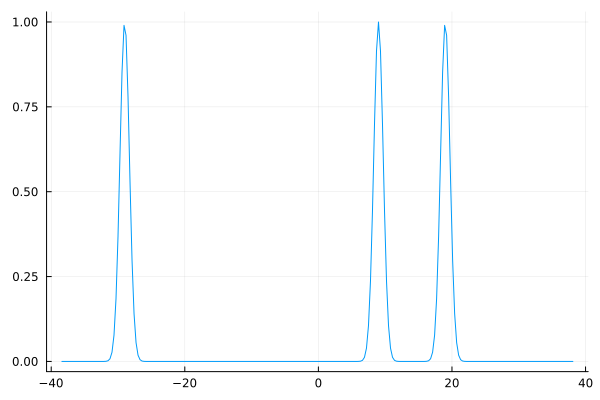

In [19]:
s0 = gen_sp_vector(k)
tau = -Nt/2:Nt/2-1
v0 = [boundary(h*i,s0) for i in tau]
time = -T/2:h:T/2-h
plot(time,abs.(v0).^2, legend=false)

### Generation of received waveform

In [20]:
obs_z = 3*LD
snr = 15
σ_n = 10^(-snr/20)
r = split_step_fourier(v0, obs_z)
y = r + σ_n*randn(ComplexF64,Nt);

In [21]:
obs_z

0.30000000000000004

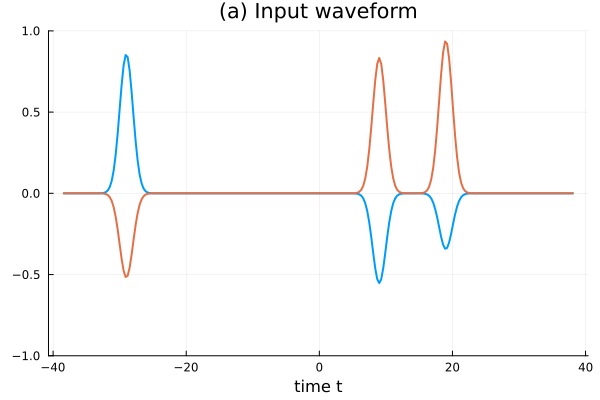

In [22]:
p1 = plot(time,real.(v0),xlabel="time t",label="real part",lw=2,legend=false, title="(a) Input waveform",yrange=[-1,1])
plot!(time,imag.(v0),xlabel="time t",label="imaginary part",lw=2)

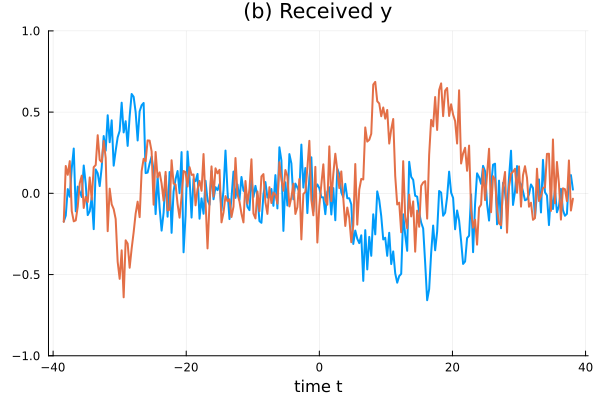

In [23]:
yfig = plot(time,real.(y),xlabel="time t",label="real part",lw=2,legend=false, title="(b) Received y",yrange=[-1,1])
plot!(time,imag.(y),xlabel="time t",label="imaginary part",lw=2)

### PA-ISTA

In [24]:
pos2index(x) = Integer(floor((x+Tmax)/h) + 1) 
wpos = pos2index.(positions); ## 符号シンボル書き込み位置インデックス

In [25]:
function jacobi(f, x)
  y, back = Zygote.pullback(f, x)
  back(1)[1], back(im)[1]
end

function wirtinger(f, x)
  du, dv = jacobi(f, x)
  (du' + im*dv')/2, (du + im*dv)/2
end

wirtinger (generic function with 1 method)

In [26]:
function backprop(v0, z)
    num_itr = Int(round(z/l))
    uu = v0
    dispersion = exp.(-0.5im*β2*ω.^2*l)
    temp = uu .* exp.(-(hhz/2)*((abs.(uu)).^2))
    for i in 1:num_itr
        f_temp = ifft(temp).* dispersion
        uu = fft(f_temp)
        temp = uu.* exp.(-hhz*(abs.(uu)).^2) 
    end
    v = temp .* exp.((hhz/2)*(abs.(uu)).^2)
    return v
end

backprop (generic function with 1 method)

In [27]:
st(x,tau) = (x/(abs(x)))*max(abs(x)-abs(tau),0) # Soft thresholding function

st (generic function with 1 method)

In [28]:
function PA_ISTA(y,obs_z,η,γ,num_itr)
    bp = backprop(y, obs_z)
    s = bp[wpos]

    for i in 1:num_itr
        v = [boundary(h*i,s) for i in tau]
        f(x) = norm(y - split_step_fourier(x, obs_z))^2 
        grad_s = wirtinger(x -> f(x), v)[2][wpos]
        s = s - abs(η[i])*grad_s 
        s = st.(s, γ[i])
    end
  return s
end

function DU_PA_ISTA(s0,y,obs_z,η,γ,opt,num_itr)
    bp = backprop(y, obs_z)
    s = bp[wpos]

    # recording phase 
    grad_history = zeros(ComplexF64,n,num_itr)
    for i in 1:num_itr
        v = [boundary(h*i,s) for i in tau]
        f(x) = norm(y - split_step_fourier(x, obs_z))^2 
        grad_s = wirtinger(x -> f(x), v)[2][wpos]
        #if any(isnan, grad_s) == true
        #    grad_s = zeros(ComplexF64,n)
        #    println("zygote NAN!")
        #end
        grad_history[:,i] = grad_s
        s = s - abs(η[i])*grad_s 
        s = st.(s, γ[i])
    end
 
    # replay phase
    s = bp[wpos]

    ps = Flux.params(η,γ)
    gs = gradient(ps) do 
        for i in 1:num_itr
            s = s - abs(η[i])*grad_history[:,i] 
            s = st.(s, γ[i])
        end
        norm(s-s0)^2
    end
    if any(isnan, gs[η]) == false && any(isnan, gs[γ]) == false 
        Flux.Optimise.update!(opt, ps, gs)
    end
    l = norm(s-s0)^2
    println(l)
    return s
end

DU_PA_ISTA (generic function with 1 method)

In [29]:
function train(train_itr,snr,obs_z,η,γ,opt,num_itr)
    for i in 1:train_itr
        s0 = gen_sp_vector(k)
        v0 = [boundary(h*i,s0) for i in tau]
        r = split_step_fourier(v0, obs_z)
        σ_n = 10^(-snr/20)
        y = r + σ_n*randn(ComplexF64,Nt);
        est = DU_PA_ISTA(s0,y,obs_z,η,γ,opt,num_itr)
    end
end

train (generic function with 1 method)

In [30]:
train_itr = 100
num_itr = 30
η_train = 0.01*ones(ComplexF64,num_itr) # step size
γ_train = 0.001*ones(ComplexF64,num_itr) 
adam_lr = 1e-4
opt = ADAM(adam_lr)
train(train_itr,snr,obs_z,η_train,γ_train,opt,num_itr)

0.7499137251095125
0.979578789881715
0.8030192267246533
0.7159664206914815
0.8081798129273841
0.7451997978866559
0.5014766191228319
0.7037926515588655
0.8281750642652536
0.732462721030664
0.7492303359720967
0.7795219098077395
0.98283203803597
0.4233152250251438
0.5860479500308288
0.7222337101198296
0.505781056156697
0.5836192261184311
0.5602973344251838
0.5221895888615506
0.5176726212575854
0.6592162661328659
0.46616693283158717
0.678031904141941
0.7729350913321741
0.2187450989345178
0.5959124169460718
0.3713070397434764
0.4135367590865588
0.47848222835231796
0.4955786706877011
0.4625327864872683
0.36598137485688614
0.5531888974677288
0.252866007383733
0.22580427352788235
0.614579238271702
0.439466400488657
0.25134135507329014
0.3993183778938332
0.3874892636301933
0.2752807771816904
0.2780646527069684
0.2869307542599851
0.31908241335854065
0.24478647416291893
0.3145330929355215
0.1922859871867933
0.18908834927895035
0.21737299208382826
0.32644154753546734
0.40533423662824114
0.55284656

In [31]:
η_train

30-element Vector{ComplexF64}:
  0.012657360376600134 + 0.0im
  0.012285073646114758 + 0.0im
  0.011804013425547478 + 0.0im
  0.011198419085936146 + 0.0im
  0.010461470841763812 + 0.0im
  0.009606392484039916 + 0.0im
  0.008674603626568795 + 0.0im
  0.007731568619825777 + 0.0im
  0.006844783449661317 + 0.0im
  0.006063894002899363 + 0.0im
 0.0054132217918843855 + 0.0im
  0.004892595224540911 + 0.0im
  0.004489006605639369 + 0.0im
                       ⋮
 0.0032853528035838423 + 0.0im
  0.003227588071674228 + 0.0im
 0.0031800708105376232 + 0.0im
 0.0031411128704517937 + 0.0im
 0.0031079317599286365 + 0.0im
  0.003078875284335687 + 0.0im
  0.003053130321071093 + 0.0im
  0.003028874135316187 + 0.0im
   0.00300604432696876 + 0.0im
  0.002984317893776113 + 0.0im
 0.0029636257425533696 + 0.0im
 0.0029438115760792487 + 0.0im

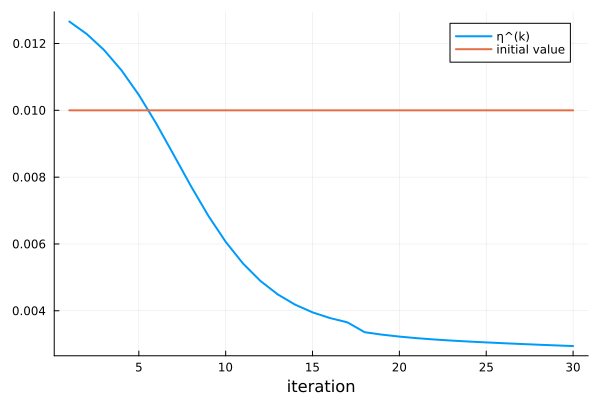

In [32]:
r1 = plot(abs.(η_train),lw=2,label="η^(k)", xlabel="iteration")
plot!(x->0.01,lw=2,label="initial value")

In [33]:
γ_train

30-element Vector{ComplexF64}:
  0.006510189957612629 + 0.0im
  0.006510190732786147 + 0.0im
  0.006510161655354788 + 0.0im
  0.006510105494609562 + 0.0im
  0.006510024864189619 + 0.0im
  0.006509922555501261 + 0.0im
  0.006509801767831502 + 0.0im
  0.006509666102980141 + 0.0im
  0.006509519302412487 + 0.0im
  0.006509364686644842 + 0.0im
  0.006509204827001784 + 0.0im
  0.006509041275290097 + 0.0im
 0.0065088742794386385 + 0.0im
                       ⋮
  0.006507909488540722 + 0.0im
 0.0065077901262716046 + 0.0im
 0.0065076786098812725 + 0.0im
 0.0065075731519553025 + 0.0im
  0.006507472840535909 + 0.0im
  0.006507377192190388 + 0.0im
 0.0065072858859921345 + 0.0im
  0.006507198877339531 + 0.0im
  0.006507116314875424 + 0.0im
  0.006507038710271798 + 0.0im
 0.0065069666864283025 + 0.0im
  0.006506900620354992 + 0.0im

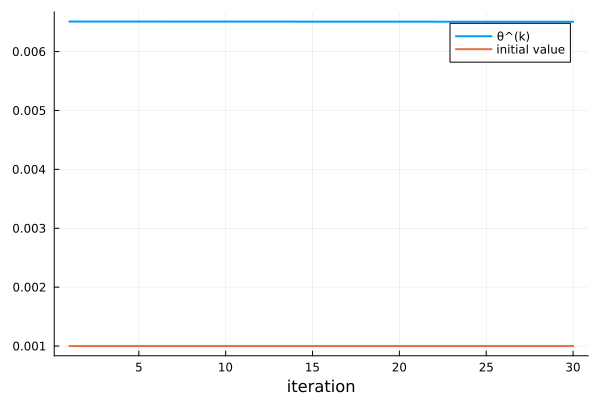

In [34]:
r2 =plot(real.(γ_train),lw=2,label="θ^(k)", xlabel="iteration")
plot!(x->0.001,lw=2,label="initial value")

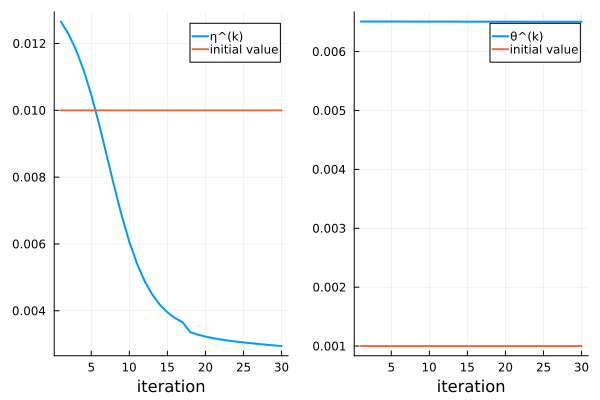

In [35]:
plot(r1,r2)

In [36]:
savefig("tuned_params.pdf")

"/Users/wadayama/Dropbox/2025-ICASSP/experiments/exp3/tuned_params.pdf"

In [37]:
s0 = gen_sp_vector(k)
v0 = [boundary(h*i,s0) for i in tau]
r = split_step_fourier(v0, obs_z)
σ_n = 10^(-snr/20)
y = r + σ_n*randn(ComplexF64,Nt);

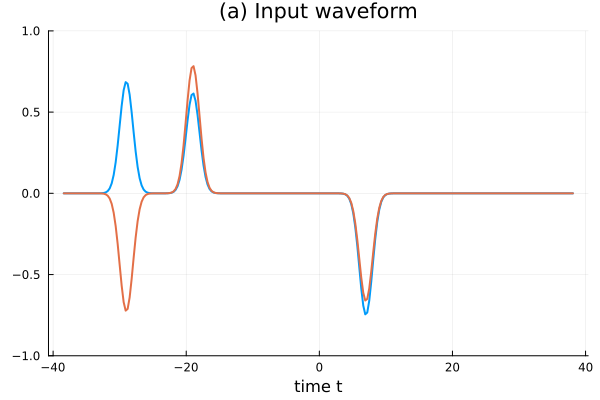

In [38]:
p1 = plot(time,real.(v0),xlabel="time t",label="real part",lw=2,legend=false, title="(a) Input waveform",yrange=[-1,1])
plot!(time,imag.(v0),xlabel="time t",label="imaginary part",lw=2)

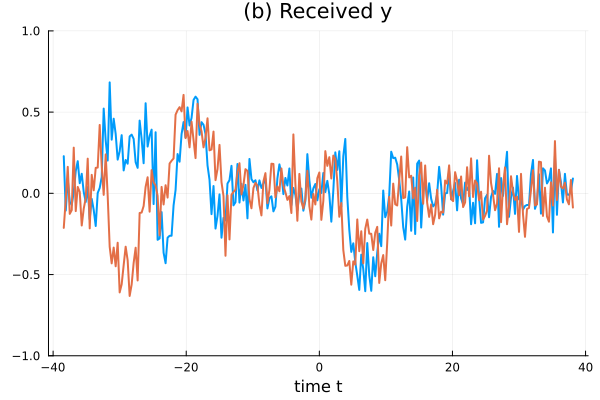

In [39]:
yfig = plot(time,real.(y),xlabel="time t",label="real part",lw=2,legend=false, title="(b) Received y",yrange=[-1,1])
plot!(time,imag.(y),xlabel="time t",label="imaginary part",lw=2)

In [40]:
est = PA_ISTA(y,obs_z,η_train,γ_train,num_itr)
vest = [boundary(h*i,est) for i in tau]

256-element Vector{ComplexF64}:
  2.966247213605781e-20 - 4.46088401722613e-20im
  4.757453263592466e-19 - 7.154645482316978e-19im
  6.973570799492902e-18 - 1.04874234284193e-17im
  9.342205043636732e-17 - 1.4049568415489137e-16im
 1.1438183832237444e-15 - 1.720167193391035e-15im
 1.2799065039020587e-14 - 1.924827587064114e-14im
 1.3089194355129275e-13 - 1.9684595953209283e-13im
 1.2233791750009422e-12 - 1.8398171884449962e-12im
 1.0450155361704649e-11 - 1.5715794292779292e-11im
  8.158266865268724e-11 - 1.2269065808342796e-10im
  5.820852097087721e-10 - 8.753871210542589e-10im
   3.795672365130258e-9 - 5.708241076661241e-9im
   2.262061291482422e-8 - 3.401871905643842e-8im
                        ⋮
 3.6660908706336618e-56 - 7.349947400020729e-56im
 3.0626976804475232e-58 - 6.1402370120640126e-58im
 2.3383985354101366e-60 - 4.688128811324124e-60im
 1.6317229718324873e-62 - 3.2713531763333936e-62im
 1.0406095845897667e-64 - 2.0862619014596934e-64im
  6.065166286722282e-67 - 1.2159724009

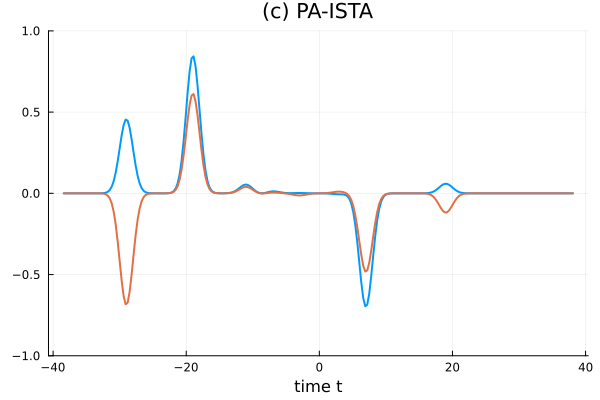

In [41]:
p2 = plot(time,real.(vest),xlabel="time t",label="real part",lw=2,legend=false, title="(c) PA-ISTA",yrange=[-1,1])
plot!(time,imag.(vest),xlabel="time t",label="imaginary part",lw=2)

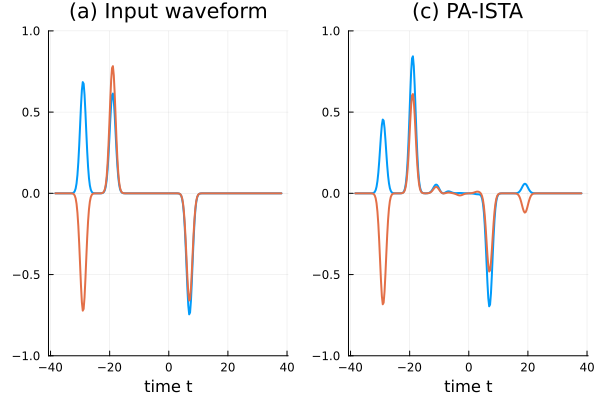

In [42]:
plot(p1,p2)

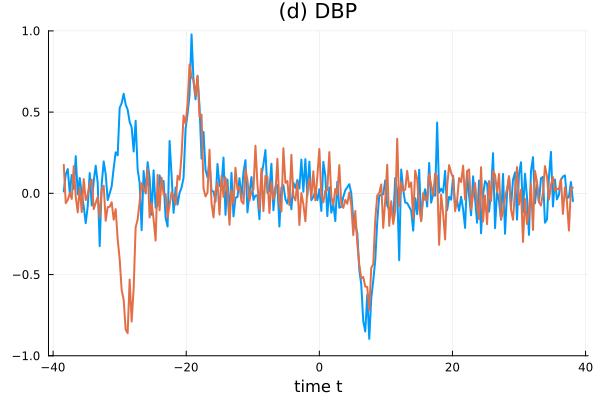

In [43]:
bp_est = backprop(y, obs_z)
p3 = plot(time,real.(bp_est),xlabel="time t",label="real part",lw=2,legend=false,title="(d) DBP",yrange=[-1,1])
plot!(time,imag.(bp_est),xlabel="time t",label="imaginary part",lw=2)

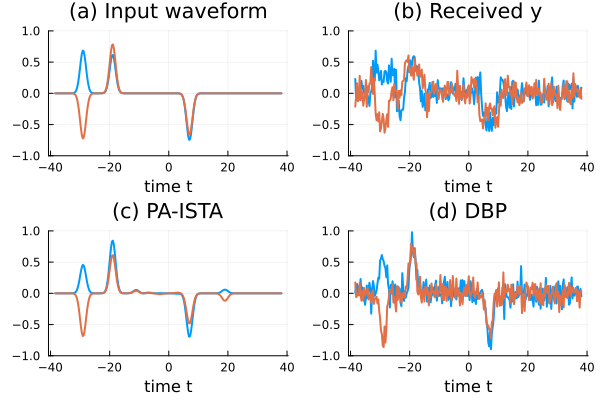

In [44]:
plot(p1,yfig,p2,p3)

In [45]:
savefig("wave.pdf")

"/Users/wadayama/Dropbox/2025-ICASSP/experiments/exp3/wave.pdf"

In [46]:
function comp_mse(snr,obs_z,η,γ,num_itr,num_trials)
    σ_n = 10^(-snr/20)
    se_sum = 0.0
    den = 0
    for i in 1:num_trials
        s0 = gen_sp_vector(k)
        v0 = [boundary(h*i,s0) for i in tau]
        r = split_step_fourier(v0, obs_z)
        y = r + σ_n*randn(ComplexF64,Nt)
        est_s = PA_ISTA(y,obs_z,η,γ,num_itr)
        if any(isnan, est_s) == false 
            den += 1
            se_sum += norm(s0-est_s)^2
        end
    end
    return se_sum/den
end

comp_mse (generic function with 1 method)

In [47]:
num_trials = 100
comp_mse(snr,obs_z,η_train,γ_train,num_itr,num_trials)

0.30099829163760256

In [48]:
itr_list = [1,5,10,15,20,25,30]

7-element Vector{Int64}:
  1
  5
 10
 15
 20
 25
 30

In [49]:
MSE_list = [comp_mse(snr,obs_z,η_train,γ_train,itr,num_trials) for itr in itr_list]

7-element Vector{Float64}:
 0.9724719403005635
 0.7957863698537265
 0.5934670593692349
 0.4618694232668155
 0.3830783680007923
 0.31599569529114063
 0.2671049281278544

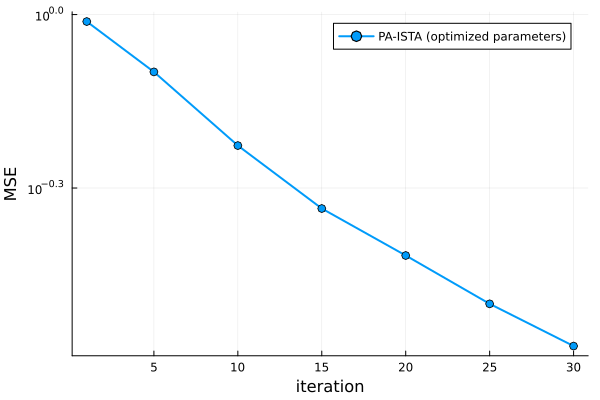

In [50]:
plot(itr_list,MSE_list, yscale=:log10,marker=:o, xlabel="iteration", ylabel="MSE", label="PA-ISTA (optimized parameters)",lw=2)

In [51]:
function comp_mse_bp(snr,obs_z,num_trials)
    σ_n = 10^(-snr/20)
    se_sum = 0.0
    den = 0
    for i in 1:num_trials
        s0 = gen_sp_vector(k)
        v0 = [boundary(h*i,s0) for i in tau]
        r = split_step_fourier(v0, obs_z)
        y = r + σ_n*randn(ComplexF64,Nt)
        est_s = backprop(y,obs_z)[wpos]
        if any(isnan, est_s) == false  
            den += 1
            se_sum += norm(s0-est_s)^2
        end
    end
    return se_sum/den
end

comp_mse_bp (generic function with 1 method)

In [52]:
η_train = 0.01*ones(ComplexF64,num_itr) # ステップサイズ
γ_train = 0.001*ones(ComplexF64,num_itr) # 符号勾配係数
MSE_list3 = [comp_mse(snr,obs_z,η_train,γ_train,itr,num_trials) for itr in itr_list]

7-element Vector{Float64}:
 1.0469491929409214
 0.9947751199064231
 0.9649191906337166
 0.8970200002838514
 0.876230743461083
 0.8470570344915881
 0.8021300819108207

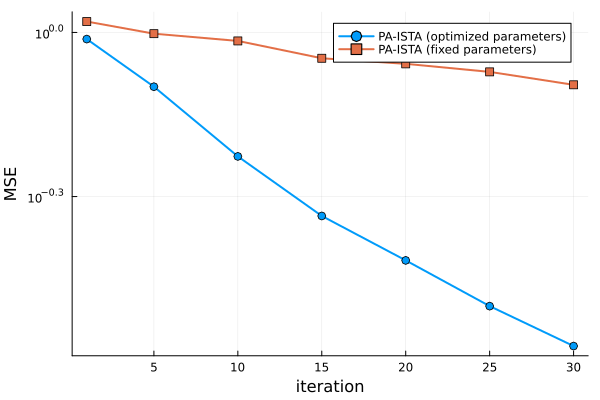

In [53]:
plot!(itr_list,MSE_list3, yscale=:log10,marker=:rect, xlabel="iteration", ylabel="MSE", label="PA-ISTA (fixed parameters)",lw=2)

In [54]:
MSE_bp_list = comp_mse_bp(snr,obs_z,num_trials) * ones(length(itr_list))

7-element Vector{Float64}:
 1.0877086806853606
 1.0877086806853606
 1.0877086806853606
 1.0877086806853606
 1.0877086806853606
 1.0877086806853606
 1.0877086806853606

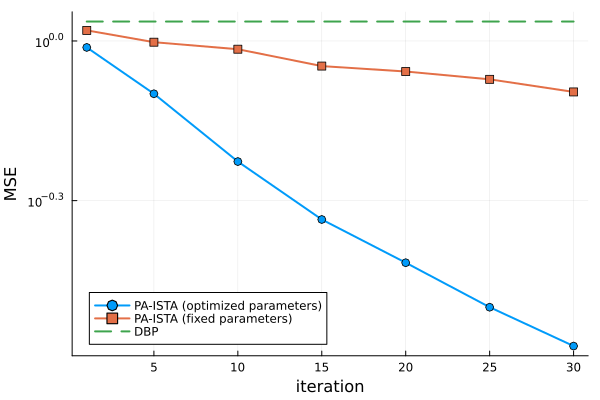

In [55]:
plot!(itr_list,MSE_bp_list,  xlabel="iteration", ylabel="MSE", label="DBP",lw=2,ls=:dash)

In [56]:
savefig("MSE.pdf")

"/Users/wadayama/Dropbox/2025-ICASSP/experiments/exp3/MSE.pdf"